<a href="https://colab.research.google.com/github/priya170807/Time-seriesAnalysis/blob/main/ATM_cash_withdrawalv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams["figure.figsize"] = 12,5
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')
import math
from scipy import stats
from google.colab import files
from sklearn.metrics import mean_squared_error
import lightgbm as lgb 
from lightgbm import LGBMRegressor
from sklearn import metrics
from time import time
from sklearn.model_selection import cross_val_score
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ATM Cash demand forecast

In [85]:
from google.colab import files
uploaded = files.upload()

Saving atm_data.csv to atm_data (1).csv


In [117]:
# Import data 
df = pd.read_csv("atm_data.csv")
df

<IPython.core.display.Javascript object>

,Unnamed: 0,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
0,11,Mount Road ATM,MONDAY,NH,W,WWW,1,1,2011,648600,897100
1,16,Mount Road ATM,TUESDAY,NH,W,WWW,1,1,2011,648600,826000
2,21,Mount Road ATM,WEDNESDAY,NH,W,WWW,1,1,2011,648600,754400
3,26,Mount Road ATM,THURSDAY,NH,W,WWW,2,1,2011,648600,834200
4,31,Mount Road ATM,FRIDAY,NH,W,WWW,2,1,2011,648600,575300
...,...,...,...,...,...,...,...,...,...,...,...
2239,11565,Mount Road ATM,MONDAY,NH,W,HWW,5,9,2017,276058,447400
2240,11570,Mount Road ATM,TUESDAY,NH,W,WWW,6,9,2017,276058,153800
2241,11575,Mount Road ATM,WEDNESDAY,NH,W,WWW,6,9,2017,276058,167100
2242,11580,Mount Road ATM,THURSDAY,NH,W,WWH,6,9,2017,276058,317400


In [118]:
df.rename({"Unnamed: 0":"increment_five"}, axis=1, inplace=True)
df['date'] = pd.to_datetime(dict(year=df.trans_year, month=df.trans_month, day=df.trans_date_set))
df.tail()

<IPython.core.display.Javascript object>

,increment_five,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn,date
2239,11565,Mount Road ATM,MONDAY,NH,W,HWW,5,9,2017,276058,447400,2017-09-05
2240,11570,Mount Road ATM,TUESDAY,NH,W,WWW,6,9,2017,276058,153800,2017-09-06
2241,11575,Mount Road ATM,WEDNESDAY,NH,W,WWW,6,9,2017,276058,167100,2017-09-06
2242,11580,Mount Road ATM,THURSDAY,NH,W,WWH,6,9,2017,276058,317400,2017-09-06
2243,11585,Mount Road ATM,FRIDAY,H,H,WHH,6,9,2017,276058,305100,2017-09-06


In [119]:
data = df.set_index('date')
data.head()

,increment_five,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
date,,,,,,,,,,,
2011-01-01,11,Mount Road ATM,MONDAY,NH,W,WWW,1,1,2011,648600,897100
2011-01-01,16,Mount Road ATM,TUESDAY,NH,W,WWW,1,1,2011,648600,826000
2011-01-01,21,Mount Road ATM,WEDNESDAY,NH,W,WWW,1,1,2011,648600,754400
2011-01-02,26,Mount Road ATM,THURSDAY,NH,W,WWW,2,1,2011,648600,834200
2011-01-02,31,Mount Road ATM,FRIDAY,NH,W,WWW,2,1,2011,648600,575300


In [120]:
new_df= data.copy()

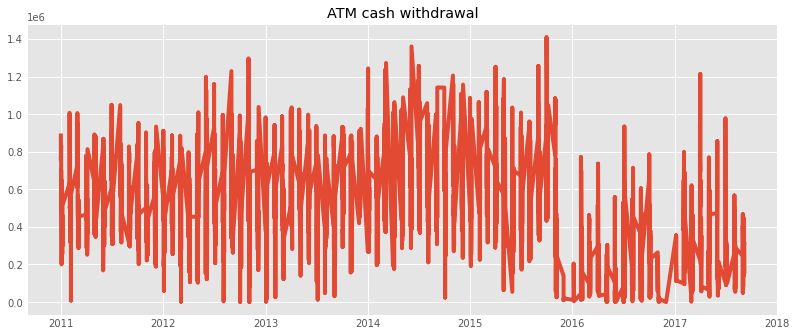

In [121]:
# plt.figure(figsize=(14,6))
plt.style.use('ggplot')
plt.plot(new_df['total_amount_withdrawn'])
plt.title('ATM cash withdrawal')
plt.show()

In [122]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2244 entries, 2011-01-01 to 2017-09-06
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   increment_five          2244 non-null   int64 
 1   atm_name                2244 non-null   object
 2   weekday                 2244 non-null   object
 3   festival_religion       2244 non-null   object
 4   working_day             2244 non-null   object
 5   holiday_sequence        2244 non-null   object
 6   trans_date_set          2244 non-null   int64 
 7   trans_month             2244 non-null   int64 
 8   trans_year              2244 non-null   int64 
 9   prevweek_mean           2244 non-null   int64 
 10  total_amount_withdrawn  2244 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 210.4+ KB


In [123]:
# Drop unecessary columns
# atm_name
new_df = new_df.drop("atm_name",axis=1)

### Target analysis
Target distribution is skewed and can be seen in the plots below - this is generally not a good thing. So we will need to adjust it so its normally distributed. This can be achieved with a log transform or something more powerful like box cox. On the diagram below, the left pane shows the original (skewed) data. The right pane show the transformed data.

count       2244.0
mean      515717.0
std       255179.0
min          100.0
25%       349475.0
50%       514100.0
75%       684925.0
max      1410700.0
Name: total_amount_withdrawn, dtype: float64

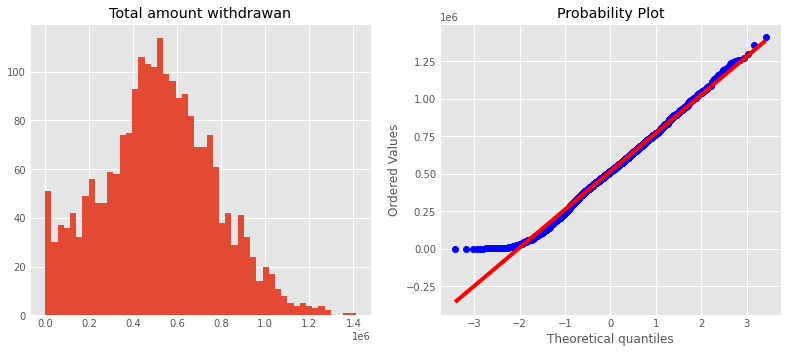

In [125]:
# plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
new_df['total_amount_withdrawn'].hist(bins=50)
plt.title('Total amount withdrawan')
plt.subplot(1,2,2)
stats.probplot(data['total_amount_withdrawn'], plot=plt);
new_df['total_amount_withdrawn'].describe().T.round()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



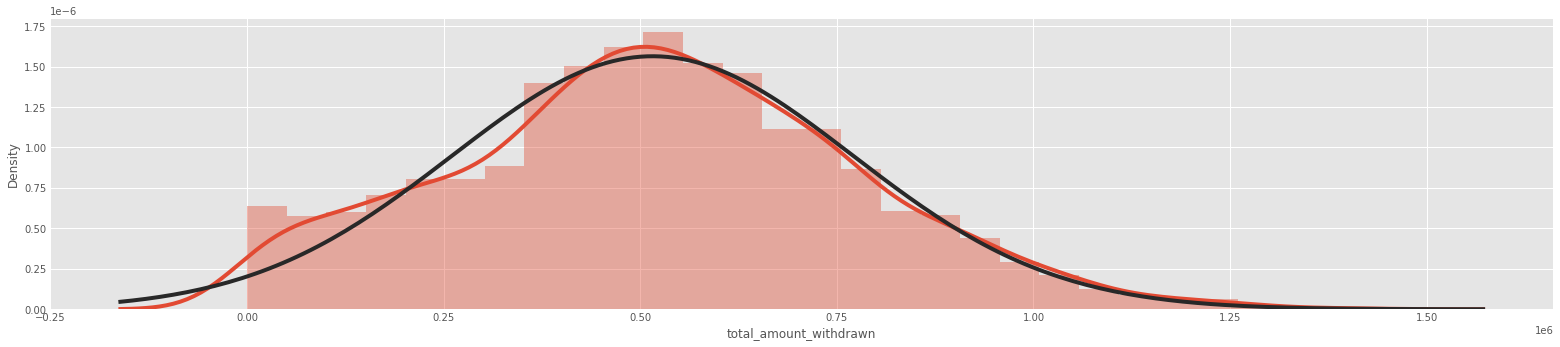

In [126]:
from scipy import stats
fig, ax = plt.subplots(1)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(new_df['total_amount_withdrawn'],fit=stats.norm)
plt.show()

In [127]:
!pip install ppscore
import ppscore as pps

In [128]:
pps.predictors(new_df, "total_amount_withdrawn")

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,prevweek_mean,total_amount_withdrawn,0.220040,regression,True,mean absolute error,203324.242424,158584.853639,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
1,trans_year,total_amount_withdrawn,0.197352,regression,True,mean absolute error,203324.242424,163197.879221,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
2,trans_date_set,total_amount_withdrawn,0.060031,regression,True,mean absolute error,203324.242424,191118.545749,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
3,increment_five,total_amount_withdrawn,0.053997,regression,True,mean absolute error,203324.242424,192345.365419,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
4,holiday_sequence,total_amount_withdrawn,0.022093,regression,True,mean absolute error,203324.242424,198832.296782,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
5,weekday,total_amount_withdrawn,0.020873,regression,True,mean absolute error,203324.242424,199080.246532,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
6,festival_religion,total_amount_withdrawn,0.004522,regression,True,mean absolute error,203324.242424,202404.721980,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
7,working_day,total_amount_withdrawn,0.004043,regression,True,mean absolute error,203324.242424,202502.160887,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
8,trans_month,total_amount_withdrawn,0.001794,regression,True,mean absolute error,203324.242424,202959.459937,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


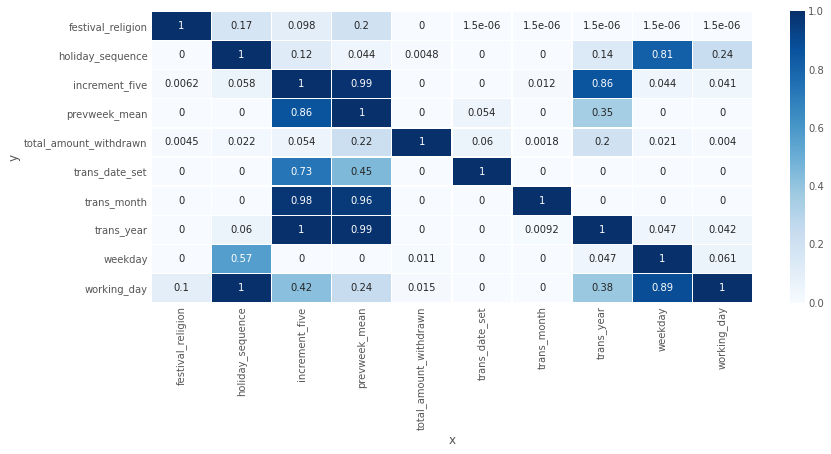

In [129]:
# plt.figure(figsize=(10,6))
import seaborn as sns
matrix_df = pps.matrix(new_df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()

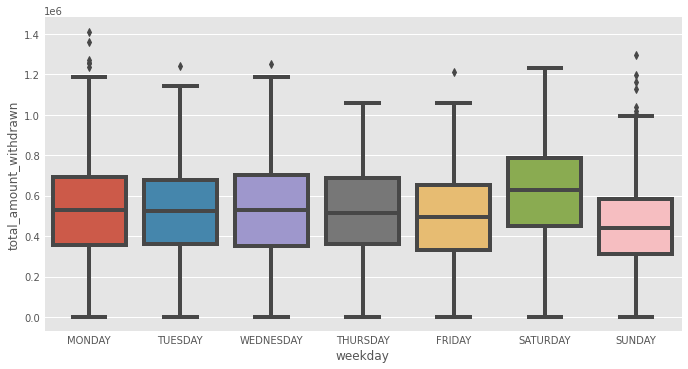

In [130]:
#cat = ['atm_name', 'weekday', 'festival_religion', 'working_day', 'holiday_sequence']

g = sns.catplot(x='weekday', y="total_amount_withdrawn", kind="box", data=new_df);
g.fig.set_size_inches(10,5)

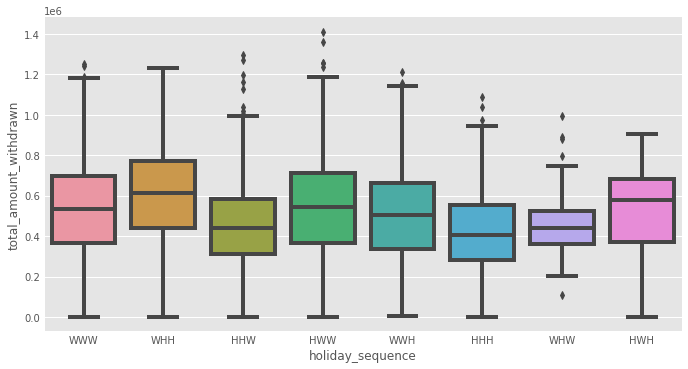

In [98]:
g = sns.catplot(x='holiday_sequence', y="total_amount_withdrawn", kind="box", data=new_df);
g.fig.set_size_inches(10,5)

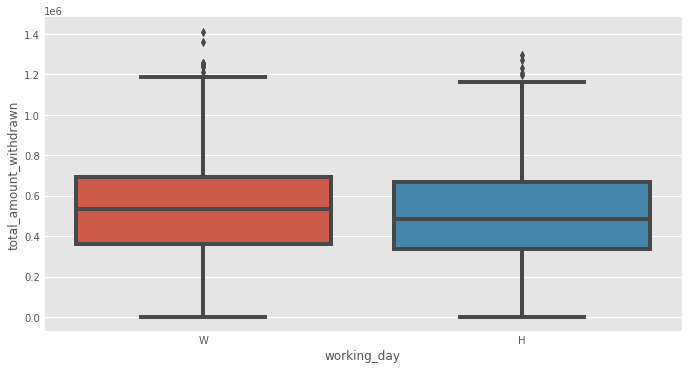

In [131]:
g = sns.catplot(x='working_day', y="total_amount_withdrawn", kind="box", data=new_df);
g.fig.set_size_inches(10,5)

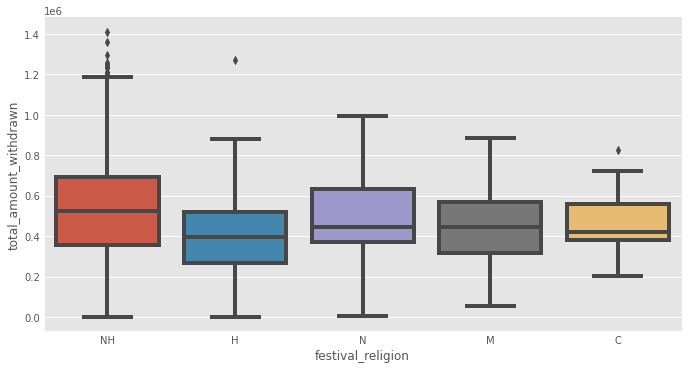

In [132]:
g = sns.catplot(x='festival_religion', y="total_amount_withdrawn", kind="box", data=new_df);
g.fig.set_size_inches(10,5)

In [133]:
new_df.columns

Index(['increment_five', 'weekday', 'festival_religion', 'working_day', 'holiday_sequence', 'trans_date_set', 'trans_month', 'trans_year',
       'prevweek_mean', 'total_amount_withdrawn'],
      dtype='object')

In [102]:
# removing the less impacting columns such as trans_date_set, trans_month, trans_year
new_df.drop(["trans_date_set", "trans_month"], axis=1, inplace=True)

In [134]:
new_df.columns

Index(['increment_five', 'weekday', 'festival_religion', 'working_day', 'holiday_sequence', 'trans_date_set', 'trans_month', 'trans_year',
       'prevweek_mean', 'total_amount_withdrawn'],
      dtype='object')

In [135]:
# Copy the original data
features = new_df.copy()

# Select the numeric columns
numeric_subset = data[['increment_five', 'prevweek_mean', 'total_amount_withdrawn']]

# Select the categorical columns
# dropped atm_name
categorical_subset = data[['weekday','festival_religion', 'working_day',	'holiday_sequence']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [136]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2244 entries, 2011-01-01 to 2017-09-06
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   increment_five          2244 non-null   int64
 1   prevweek_mean           2244 non-null   int64
 2   total_amount_withdrawn  2244 non-null   int64
 3   weekday_FRIDAY          2244 non-null   uint8
 4   weekday_MONDAY          2244 non-null   uint8
 5   weekday_SATURDAY        2244 non-null   uint8
 6   weekday_SUNDAY          2244 non-null   uint8
 7   weekday_THURSDAY        2244 non-null   uint8
 8   weekday_TUESDAY         2244 non-null   uint8
 9   weekday_WEDNESDAY       2244 non-null   uint8
 10  festival_religion_C     2244 non-null   uint8
 11  festival_religion_H     2244 non-null   uint8
 12  festival_religion_M     2244 non-null   uint8
 13  festival_religion_N     2244 non-null   uint8
 14  festival_religion_NH    2244 non-null   uint8
 15  wor

In [137]:
X = features.copy().drop(columns = ['total_amount_withdrawn'])
y = features['total_amount_withdrawn'].copy()

In [138]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of Xtrain and Xtest: ', len(Xtrain), len(Xtest))
print('length of ytrain and ytest: ', len(ytrain), len(ytest))

<IPython.core.display.Javascript object>

length of Xtrain and Xtest:  1795 449
length of ytrain and ytest:  1795 449


In [139]:
from sklearn.metrics import r2_score

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

## XGBoost

In [141]:
xgb = XGBRegressor(objective = 'reg:squarederror')
xgb.fit(Xtrain, ytrain)
# make predictions
xgb_pred = xgb.predict(Xtest)

In [142]:
xgb = XGBRegressor(objective = 'reg:squarederror')
xgb.fit(Xtrain, ytrain)
# make predictions
xgb_pred = xgb.predict(Xtest)
d = pd.DataFrame(new_df['total_amount_withdrawn']).tail(10) # calling last 10 values of original amt wothdrawn
xgbpred = pd.DataFrame(xgb_pred[-10:])
xgbpred.rename(columns = {0: 'xgb_predicted'}, inplace=True)
xgbpred = xgbpred.round(decimals=0)
xgbpred.index = d.index
xgbok = pd.concat([xgbpred, d], axis=1)
xgbok['accuracy'] = round(xgbok.apply(lambda row: row.xgb_predicted / 
                                            row.total_amount_withdrawn *100, axis = 1),2)
xgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in xgbok['accuracy']], 
                                     index = xgbok.index)
xgbok = xgbok.assign(day_of_week = lambda x: x.index.day_name())
xgbok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,xgb_predicted,total_amount_withdrawn,accuracy,day_of_week
date,,,,
2017-09-04,279099.0,308400,90.50%,Monday
2017-09-05,279566.0,312600,89.43%,Tuesday
2017-09-05,192967.0,337100,57.24%,Tuesday
2017-09-05,268375.0,251100,106.88%,Tuesday
2017-09-05,224635.0,182700,122.95%,Tuesday
2017-09-05,259154.0,447400,57.92%,Tuesday
2017-09-06,308648.0,153800,200.68%,Wednesday
2017-09-06,279099.0,167100,167.03%,Wednesday
2017-09-06,261249.0,317400,82.31%,Wednesday


<IPython.core.display.Javascript object>

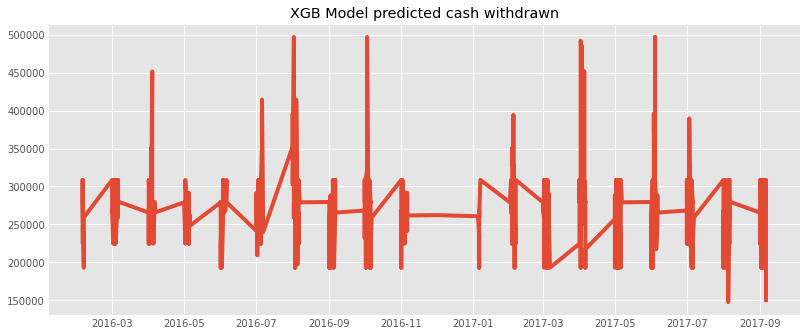

In [143]:
xgbPred = pd.DataFrame(xgb_pred)
xgbPred.index = ytest.index
plt.plot(xgbPred, label = 'Actual withdrawal')
plt.title('XGB Model predicted cash withdrawn')
plt.show()

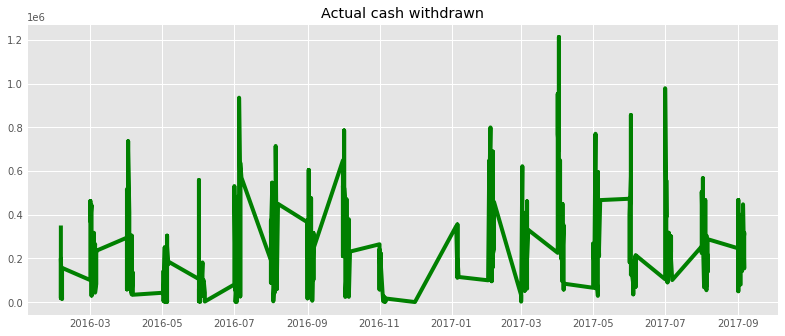

In [144]:
plt.plot(ytest, label = 'Actual withdrawal', color='g')
plt.title('Actual cash withdrawn')
plt.show()

<IPython.core.display.Javascript object>

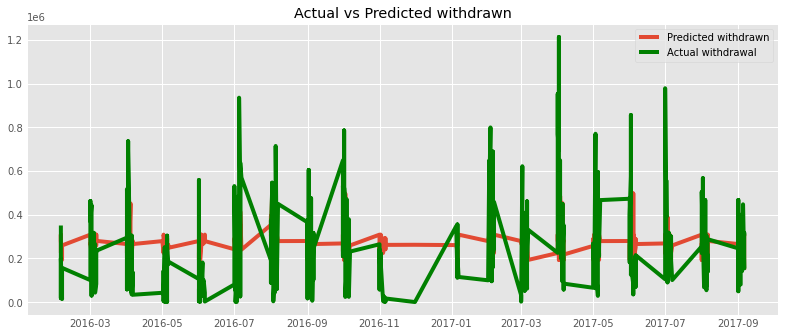

In [145]:
xgbPred = pd.DataFrame(xgb_pred)
xgbPred.index = ytest.index
plt.plot(xgbPred, label = 'Predicted withdrawn')
plt.plot(ytest, color='g', label = 'Actual withdrawal')
plt.legend(loc='best')
plt.title('Actual vs Predicted withdrawn')
plt.show()

In [146]:
mean_xgb_test = ytest.mean()
mean_xgb_pred = xgb_pred.mean()
print(mean_xgb_test, mean_xgb_pred)

accuracy = (mean_xgb_test / mean_xgb_pred)*100
print('accuracy:', round(accuracy,2))


246600.89086859688 272363.28
accuracy: 90.54


In [116]:
pip install shap

     |████████████████████████████████| 358kB 3.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=e267a9345a9fe078fbc0f4cc56c8327d97176f6ad1621478083b5f776aba4a88
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


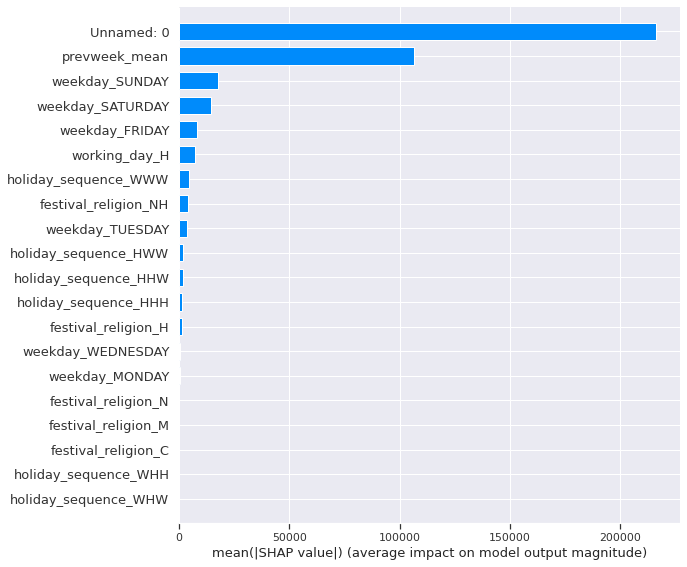

In [ ]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(Xtest)
shap.summary_plot(shap_values, Xtest, plot_type="bar")

In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()
# j will be the record we explain
j = 1

explainerXGB = shap.TreeExplainer(xgb)
shap_values_XGB_test = explainerXGB.shap_values(Xtest)
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], Xtest.iloc[[j]])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
# visualize the training set predictions
# load JS visualization code to notebook
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values, Xtest)

## Artifical neural network

In [ ]:
Data = features.values # converting numpy array
tr_data = math.ceil(len(Data)*0.8)
te_data = len(features) - tr_data # remaining is test data
print(tr_data, te_data)

# split the actual dataframe in train/test set
train, test = features.iloc[0:tr_data], features.iloc[tr_data : len(features)]
print(train.shape, test.shape)

1796 448
(1796, 27) (448, 27)


In [ ]:
test.tail()

In [ ]:
# Feature Scaling Normalization
scaler = MinMaxScaler()
training_data = scaler.fit_transform(train)
print(training_data)
print('\n')
print(training_data.shape)


[[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 ...
 [0.5        0.09090909 1.         ... 0.         1.         0.        ]
 [0.5        0.09090909 1.         ... 0.         0.         0.        ]
 [0.66666667 0.09090909 1.         ... 0.         0.         0.        ]]


(1796, 27)


In [ ]:
# shaping data from neural network
X_train = []
y_train = []
for i in range(7, training_data.shape[0]): 
  X_train.append(training_data[i-7:i])
  y_train.append(training_data[i,0])
  if i <= 8:
    print(X_train)
    print('\n')
    print(y_train)
    print()

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)


[array([[0.        , 0.        , 0.        , 0.64356352, 0.63582217,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.64356352, 0.58540736,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.64356352, 0.53463802,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1789, 7, 27) (1789,)


In [ ]:
# Call neural network API
ann = tf.keras.Sequential()

ann.add(tf.keras.layers.LSTM(units = 10,
                             activation = 'relu', 
                             return_sequences = True, 
                             input_shape = (X_train.shape[1], 27))) 
ann.add(tf.keras.layers.Dropout(0.1))
ann.add(tf.keras.layers.LSTM(units = 20, activation='relu', return_sequences = True))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.LSTM(units = 30, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.3))
ann.add(tf.keras.layers.Dense(units = 1))

ann.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 10)             1520      
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 20)             2480      
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 20)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                6120      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
# Compile the model
ann.compile(optimizer='adam',
              loss='mean_squared_error')

# Train the model
num_epochs = 10
batch_size = 32

ann.fit(X_train, y_train, 
                   epochs = num_epochs, 
                   batch_size = batch_size)

Epoch 1/10
56/56 [==============================] - 1s 10ms/step - loss: 0.1478
Epoch 2/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0903
Epoch 3/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0878
Epoch 4/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0843
Epoch 5/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0805
Epoch 6/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0795
Epoch 7/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0794
Epoch 8/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0768
Epoch 9/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0706
Epoch 10/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0697


In [ ]:
last_7_days = train.tail(7) # look back 7days
features = last_7_days.append(test)
features.head()

,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn,weekday_FRIDAY,weekday_MONDAY,weekday_SATURDAY,weekday_SUNDAY,weekday_THURSDAY,weekday_TUESDAY,weekday_WEDNESDAY,festival_religion_C,festival_religion_H,festival_religion_M,festival_religion_N,festival_religion_NH,working_day_H,working_day_W,holiday_sequence_HHH,holiday_sequence_HHW,holiday_sequence_HWH,holiday_sequence_HWW,holiday_sequence_WHH,holiday_sequence_WHW,holiday_sequence_WWH,holiday_sequence_WWW
1789,3,2,2016,283617,273000,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
1790,3,2,2016,293750,214300,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
1791,4,2,2016,293750,192600,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1792,4,2,2016,293750,131100,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1793,4,2,2016,293750,55100,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


In [ ]:
input = scaler.transform(features)
input

array([[0.33333333, 0.09090909, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.09090909, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.09090909, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.83333333, 0.72727273, 1.2       , ..., 0.        , 0.        ,
        1.        ],
       [0.83333333, 0.72727273, 1.2       , ..., 0.        , 1.        ,
        0.        ],
       [0.83333333, 0.72727273, 1.2       , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# shaping data from neural network
X_test = []
y_test = []
for i in range(7, input.shape[0]):
  X_test.append(input[i-7:i])
  y_test.append(input[i,0])

X_test, y_test= np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(448, 7, 27) (448,)


In [ ]:
y_test

In [ ]:
ann_pred = ann.predict(X_test, verbose=1)

14/14 [==============================] - 0s 2ms/step


In [ ]:
scaler.scale_

array([1.66666667e-01, 9.09090909e-02, 2.00000000e-01, 9.94996164e-07,
       7.09068992e-07, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [ ]:
scale = 1/7.09068992e-07
scale

1410300.0008213588

In [ ]:
ann_pred = ann_pred * scale
y_test = y_test * scale

In [ ]:
test['total_amount_withdrawn'].tail(10)

2234    308400
2235    312600
2236    337100
2237    251100
2238    182700
2239    447400
2240    153800
2241    167100
2242    317400
2243    305100
Name: total_amount_withdrawn, dtype: int64

In [ ]:
pd.DataFrame(ann_pred)

In [ ]:
y_test

In [ ]:
annpred = pd.DataFrame(ann_pred[-10:])
annpred.rename(columns = {0: 'ann_predicted'}, inplace=True)
annpred = annpred.round(decimals=0)

annok = pd.concat([annpred['ann_predicted'], d['total_amount_withdrawn'].tail(10)], axis=1)
annok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ann_predicted,total_amount_withdrawn
0,543390.0,308400
1,572483.0,312600
2,550465.0,337100
3,597518.0,251100
4,579181.0,182700
5,568751.0,447400
6,591620.0,153800
7,672476.0,167100
8,742972.0,317400
9,704591.0,305100


In [ ]:
plt.figure(figsize = (14,5))
plt.plot(ann_pred, label = 'Predicted withdrawal')
plt.plot(ytest, label = 'Actual withdrawal')
plt.title ('ANN - ATM cash replenishment')
plt.xlabel('Frequency')
plt.ylabel('Amount (Currency)')
plt.legend()
plt.show()

In [ ]:
mean_ann_pred = ann_pred.mean()
accuracy = (mean_ann_pred / ytest.mean())*100
print('accuracy:', accuracy)


accuracy: 219.4723164193245


## LighGBM

In [ ]:
cat_cols = ['weekday','festival_religion', 'working_day',	'holiday_sequence']
pred_cols = ['total_amount_withdrawn']

num_cols = [x for x in list(data.columns.values) if x not in cat_cols if x not in pred_cols]

### Convert categorial variables to dense vectors

In [ ]:
X = data.drop(columns=['atm_name', 'total_amount_withdrawn' ], axis=1)
y = data['total_amount_withdrawn']

In [ ]:
# Transform categorical features into the appropriate type that is expected by LightGBM.
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  1795 449
length of y_train and y_test:  1795 449


In [ ]:
X_train.tail()

,Unnamed: 0,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean
date,,,,,,,,,
2016-02-03,9192,MONDAY,NH,W,HWW,3,2,2016,293750
2016-02-04,9201,WEDNESDAY,NH,W,WWW,4,2,2016,293750
2016-02-04,9206,THURSDAY,NH,W,WWW,4,2,2016,293750
2016-02-04,9211,FRIDAY,NH,W,WWH,4,2,2016,293750
2016-02-04,9216,SATURDAY,NH,H,WHH,4,2,2016,293750


LightGBM offers good accuracy with integer-encoded categorical features.
LightGBM applies Fisher (1958) to find the optimal split over categories as described here. This often performs better than one-hot encoding.

Categorical features must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a contiguous range of integers.
Use categorical_feature to specify the categorical features. Refer to the parameter categorical_feature in Parameters.

For a categorical feature with high cardinality (#category is large), it often works best to treat the feature as numeric, either by simply ignoring the categorical interpretation of the integers or by embedding the categories in a low-dimensional numeric space.

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols,
                          free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, categorical_feature=cat_cols,
                          free_raw_data=False, reference=lgb_train)

In [ ]:
start = time()

gbm = LGBMRegressor(objective='regression', num_leaves=31, 
                    random_state=42, learning_rate=0.1, n_estimators=100)

gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
        eval_metric='rmse', early_stopping_rounds=10, verbose=50)

elapse = time() - start
print('elapse:, ', elapse)
print(); print(gbm)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[28]	valid_0's l2: 3.35189e+10	valid_0's rmse: 183082
elapse:,  0.0783848762512207

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=42, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)


In [ ]:
lgb_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)


In [ ]:
lgb_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

lgbpred = pd.DataFrame(lgb_pred[-10:])
lgbpred.rename(columns = {0: 'lgb_predicted'}, inplace=True)
lgbpred = lgbpred.round(decimals=0)
lgbpred.index = d.index
lgbok = pd.concat([lgbpred, d], axis=1)
lgbok['accuracy'] = round(lgbok.apply(lambda row: row.lgb_predicted / 
                                            row.total_amount_withdrawn *100, axis = 1),2)
lgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in lgbok['accuracy']], 
                                     index = lgbok.index)
lgbok = lgbok.assign(day_of_week = lambda x: x.index.day_name())
lgbok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,lgb_predicted,total_amount_withdrawn,accuracy,day_of_week
date,,,,
2017-09-04,208371.0,308400,67.57%,Monday
2017-09-05,173290.0,312600,55.44%,Tuesday
2017-09-05,186201.0,337100,55.24%,Tuesday
2017-09-05,208036.0,251100,82.85%,Tuesday
2017-09-05,213126.0,182700,116.65%,Tuesday
2017-09-05,197813.0,447400,44.21%,Tuesday
2017-09-06,205884.0,153800,133.86%,Wednesday
2017-09-06,208036.0,167100,124.50%,Wednesday
2017-09-06,194272.0,317400,61.21%,Wednesday


<IPython.core.display.Javascript object>

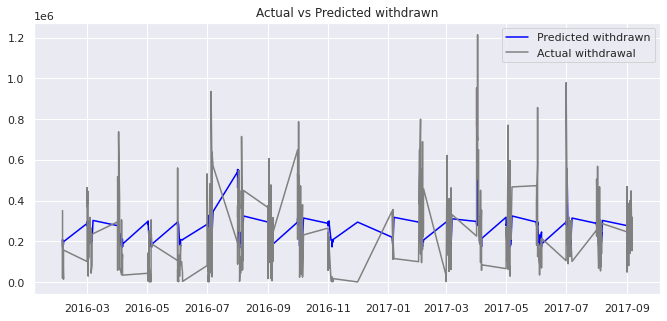

In [ ]:
lgbPred = pd.DataFrame(lgb_pred)
lgbPred.index = y_test.index
plt.plot(lgbPred, color = 'blue', label = 'Predicted withdrawn')
plt.plot(y_test, color='gray', label = 'Actual withdrawal')
plt.legend(loc='best')
plt.title('Actual vs Predicted withdrawn')
plt.show()

In [ ]:
lgb_pred

In [ ]:
gbm.predict(X_test.iloc[[0]])

array([267730.73911932])

In [ ]:
X_test.iloc[[0]]

,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean
1795,Mount Road ATM,SUNDAY,NH,H,HHW,5,2,2016,293750


In [ ]:
y_test[-1:]

array([305100])

In [ ]:
mean_lgb_test = y_test.mean()
mean_lgb_pred = lgb_pred.mean()
print(mean_lgb_test, mean_lgb_pred)

accuracy = (mean_lgb_test / mean_lgb_pred)*100
print(round(accuracy,2))

246600.89086859688 238638.10094315404
103.34


<IPython.core.display.Javascript object>

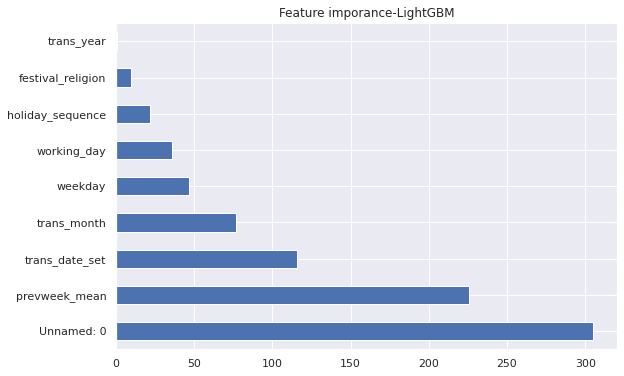

In [ ]:
feat_imp = pd.Series(gbm.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8, 6))
plt.title('Feature imporance-LightGBM')
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


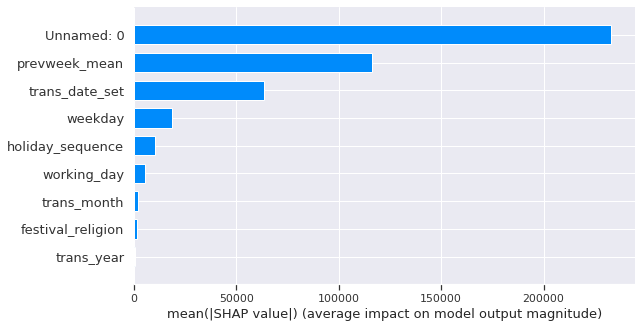

In [ ]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

##CatBoost

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  1795 449
length of y_train and y_test:  1795 449


In [ ]:
cat = CatBoostRegressor(random_seed=42)
start = time()
cat.fit(X_train, y_train,cat_features = cat_cols,eval_set=[(X_test, y_test)],
        early_stopping_rounds=10, verbose=50,plot=True)
cat_elapse = time() - start
print('elapse:, ', cat_elapse)
print(); print(cat)

# make predictions
cat_pred = cat.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.051464
0:	learn: 220479.2152029	test: 383209.5943054	best: 383209.5943054 (0)	total: 57.1ms	remaining: 57.1s
50:	learn: 168275.6815404	test: 195095.4003558	best: 195095.4003558 (50)	total: 256ms	remaining: 4.76s
100:	learn: 159828.6071573	test: 185165.4972232	best: 185066.1174495 (99)	total: 418ms	remaining: 3.72s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 184233.4538
bestIteration = 134

Shrink model to first 135 iterations.
elapse:,  0.6429719924926758



In [ ]:
catpred = pd.DataFrame(cat_pred[-10:])
catpred.rename(columns = {0: 'cat_predicted'}, inplace=True)
catpred = catpred.round(decimals=0)
catpred.index = d.index
catok = pd.concat([catpred, d], axis=1)
catok['accuracy'] = round(catok.apply(lambda row: row.cat_predicted / 
                                            row.total_amount_withdrawn *100, axis = 1),2)
catok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in catok['accuracy']], 
                                     index = catok.index)
catok = catok.assign(day_of_week = lambda x: x.index.day_name())
catok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,cat_predicted,total_amount_withdrawn,accuracy,day_of_week
date,,,,
2017-09-04,206394.0,308400,66.92%,Monday
2017-09-05,218159.0,312600,69.79%,Tuesday
2017-09-05,211779.0,337100,62.82%,Tuesday
2017-09-05,238314.0,251100,94.91%,Tuesday
2017-09-05,187144.0,182700,102.43%,Tuesday
2017-09-05,198053.0,447400,44.27%,Tuesday
2017-09-06,220239.0,153800,143.20%,Wednesday
2017-09-06,201537.0,167100,120.61%,Wednesday
2017-09-06,213910.0,317400,67.39%,Wednesday


<IPython.core.display.Javascript object>

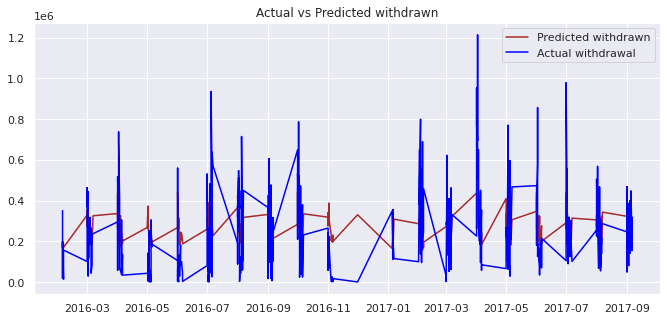

In [ ]:
catPred = pd.DataFrame(cat_pred)
catPred.index = y_test.index
plt.plot(catPred, color = 'brown', label = 'Predicted withdrawn')
plt.plot(y_test, color='blue', label = 'Actual withdrawal')
plt.legend(loc='best')
plt.title('Actual vs Predicted withdrawn')
plt.show()

In [ ]:
mean_cat_test = y_test.mean()
mean_cat_pred = cat_pred.mean()
print(mean_cat_test, mean_cat_pred)

accuracy = (mean_cat_test / mean_cat_pred)*100
print('accuracy:', round(accuracy,2))

246600.89086859688 256074.37458396674
accuracy: 96.3


<IPython.core.display.Javascript object>

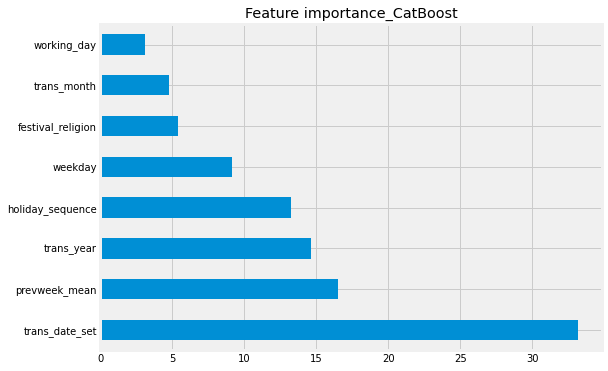

In [ ]:
featimp = pd.Series(cat.feature_importances_, index=X.columns)
featimp.nlargest(10).plot(kind='barh', figsize=(8,6))
plt.title('Feature importance_CatBoost')
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


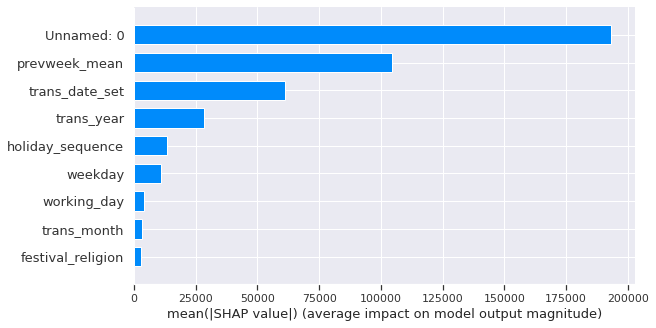

In [ ]:
shap_values = shap.TreeExplainer(cat).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
catpred = pd.DataFrame(cat_pred[-10:])
catpred.rename(columns = {0: 'cat_predicted'}, inplace=True)
catpred = catpred.round(decimals=0)

catok = pd.concat([catpred['cat_predicted'], d['total_amount_withdrawn'].tail(10)], axis=1)
catok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,cat_predicted,total_amount_withdrawn
0,198002.0,308400
1,235345.0,312600
2,213685.0,337100
3,249329.0,251100
4,243029.0,182700
5,181678.0,447400
6,217245.0,153800
7,201877.0,167100
8,213344.0,317400
9,332566.0,305100


In [ ]:
report = pd.concat([catok['cat_predicted'], lgbok['lgb_predicted'], xgbok['xgb_predicted'], linok], axis=1)
report.drop(columns=['accuracy'], axis=1, inplace=True)
report


<IPython.core.display.Javascript object>

,cat_predicted,lgb_predicted,xgb_predicted,lin_predicted,total_amount_withdrawn,day_of_week
date,,,,,,
2017-09-04,206394.0,208371.0,279099.0,531572.0,308400,Monday
2017-09-05,218159.0,173290.0,279566.0,511144.0,312600,Tuesday
2017-09-05,211779.0,186201.0,192967.0,484461.0,337100,Tuesday
2017-09-05,238314.0,208036.0,268375.0,596708.0,251100,Tuesday
2017-09-05,187144.0,213126.0,224635.0,400519.0,182700,Tuesday
2017-09-05,198053.0,197813.0,259154.0,553561.0,447400,Tuesday
2017-09-06,220239.0,205884.0,308648.0,528931.0,153800,Wednesday
2017-09-06,201537.0,208036.0,279099.0,541335.0,167100,Wednesday
2017-09-06,213910.0,194272.0,261249.0,544788.0,317400,Wednesday
